In [1]:
!wget https://raw.githubusercontent.com/pSzyc/Ising/main/Model/input_pipeline.py

--2023-11-28 14:34:54--  https://raw.githubusercontent.com/pSzyc/Ising/main/Model/input_pipeline.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2940 (2.9K) [text/plain]
Saving to: ‘input_pipeline.py’

input_pipeline.py   100%[===================>]   2.87K  --.-KB/s    in 0s      

2023-11-28 14:34:54 (48.5 MB/s) - ‘input_pipeline.py’ saved [2940/2940]



In [4]:


import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import csv
from google.colab import drive
from pathlib import Path
from input_pipeline import dataset_tfrecord_pipeline
drive.mount('/content/drive')
data_path = "drive/MyDrive/Licencjat/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataset

In [5]:
trainset_path = f"{data_path}/trainset.tfrecord"
testset_path =  f"{data_path}/testset.tfrecord"
batch_size = 120
train_set = dataset_tfrecord_pipeline(trainset_path, flatten=False, batch_size=batch_size)
test_set = dataset_tfrecord_pipeline(testset_path, flatten=False, batch_size=batch_size)

Getting data from drive/MyDrive/Licencjat//trainset.tfrecord
Getting data from drive/MyDrive/Licencjat//testset.tfrecord


# Model

In [13]:
class VAE(tf.keras.Model):
  """Variational autoencoder."""

  def __init__(self, latent_dim, kernel_size = 3):
    super(VAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
          tf.keras.layers.Conv2D(32, kernel_size, activation='relu', padding="same", input_shape=(32, 32, 1)),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.MaxPooling2D((2, 2)),
          tf.keras.layers.Dropout(0.5),
          tf.keras.layers.Conv2D(64, kernel_size, padding="same", activation='relu'),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.MaxPooling2D((2, 2)),
          tf.keras.layers.Dropout(0.5),
          tf.keras.layers.Conv2D(64, kernel_size, padding="same", activation='relu'),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Dropout(0.5),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(latent_dim + latent_dim)
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
          tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
          tf.keras.layers.Dense(units=8*8*32, activation=tf.nn.relu),
          tf.keras.layers.Reshape(target_shape=(8, 8, 32)),
          tf.keras.layers.Conv2DTranspose(64, kernel_size, padding="same",activation='relu'),
          tf.keras.layers.UpSampling2D(size=(2, 2)),
          tf.keras.layers.Conv2DTranspose(64, kernel_size, padding="same",activation='relu'),
          tf.keras.layers.UpSampling2D(size=(2, 2)),
          tf.keras.layers.Conv2DTranspose(32, kernel_size, padding="same",activation='relu'),
          tf.keras.layers.Conv2DTranspose(1, kernel_size,  padding="same"),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))


# Training

In [14]:
optimizer = tf.keras.optimizers.Adam(1e-4)
epochs = 70
latent_dim = 400

num_examples_to_generate = 5
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])

model = VAE(latent_dim)

In [15]:
#try:
#  model(np.zeros( (1, 64 , 64)))
#except:
#  model.load_weights(f'{data_path}/Model/vae.h5')

In [19]:
def plot_spins(path, predictions, originals):
    fig = plt.figure(figsize=(15, 20))
    subfigs = fig.subfigures(nrows=len(predictions), ncols=1)

    for index, subfig in enumerate(subfigs):
        subfig.suptitle(f'Sample nr: {index}')
        axs = subfig.subplots(nrows=1, ncols=4)

        axs[0].imshow(predictions[index, :, :, 0], vmin=0, vmax=1)
        axs[0].axis('off')
        axs[0].set_title("Spin +1 probability map")

        axs[1].imshow(np.random.binomial(1, predictions[index, :, :, 0]), vmin=0, vmax=1)
        axs[1].axis('off')
        axs[1].set_title("Predicted from binomial")

        axs[2].imshow(predictions[index, :, :, 0] > 0.5, vmin=0, vmax=1)
        axs[2].axis('off')
        axs[2].set_title("p > 0.5")

        axs[3].imshow(originals[index, :, :, 0], vmin=0, vmax=1)
        axs[3].axis('off')
        axs[3].set_title("Original Sample")


    plt.savefig(path)
    plt.show()

def generate_and_save_images(model, epoch, test_sample):
  predictions = make_prediction(model, test_sample)
  plot_spins(f'{data_path}/Images/image_at_epoch_{epoch}.png', predictions, test_sample)

def make_prediction(model, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    return predictions

In [20]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_set.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

FileNotFoundError: ignored

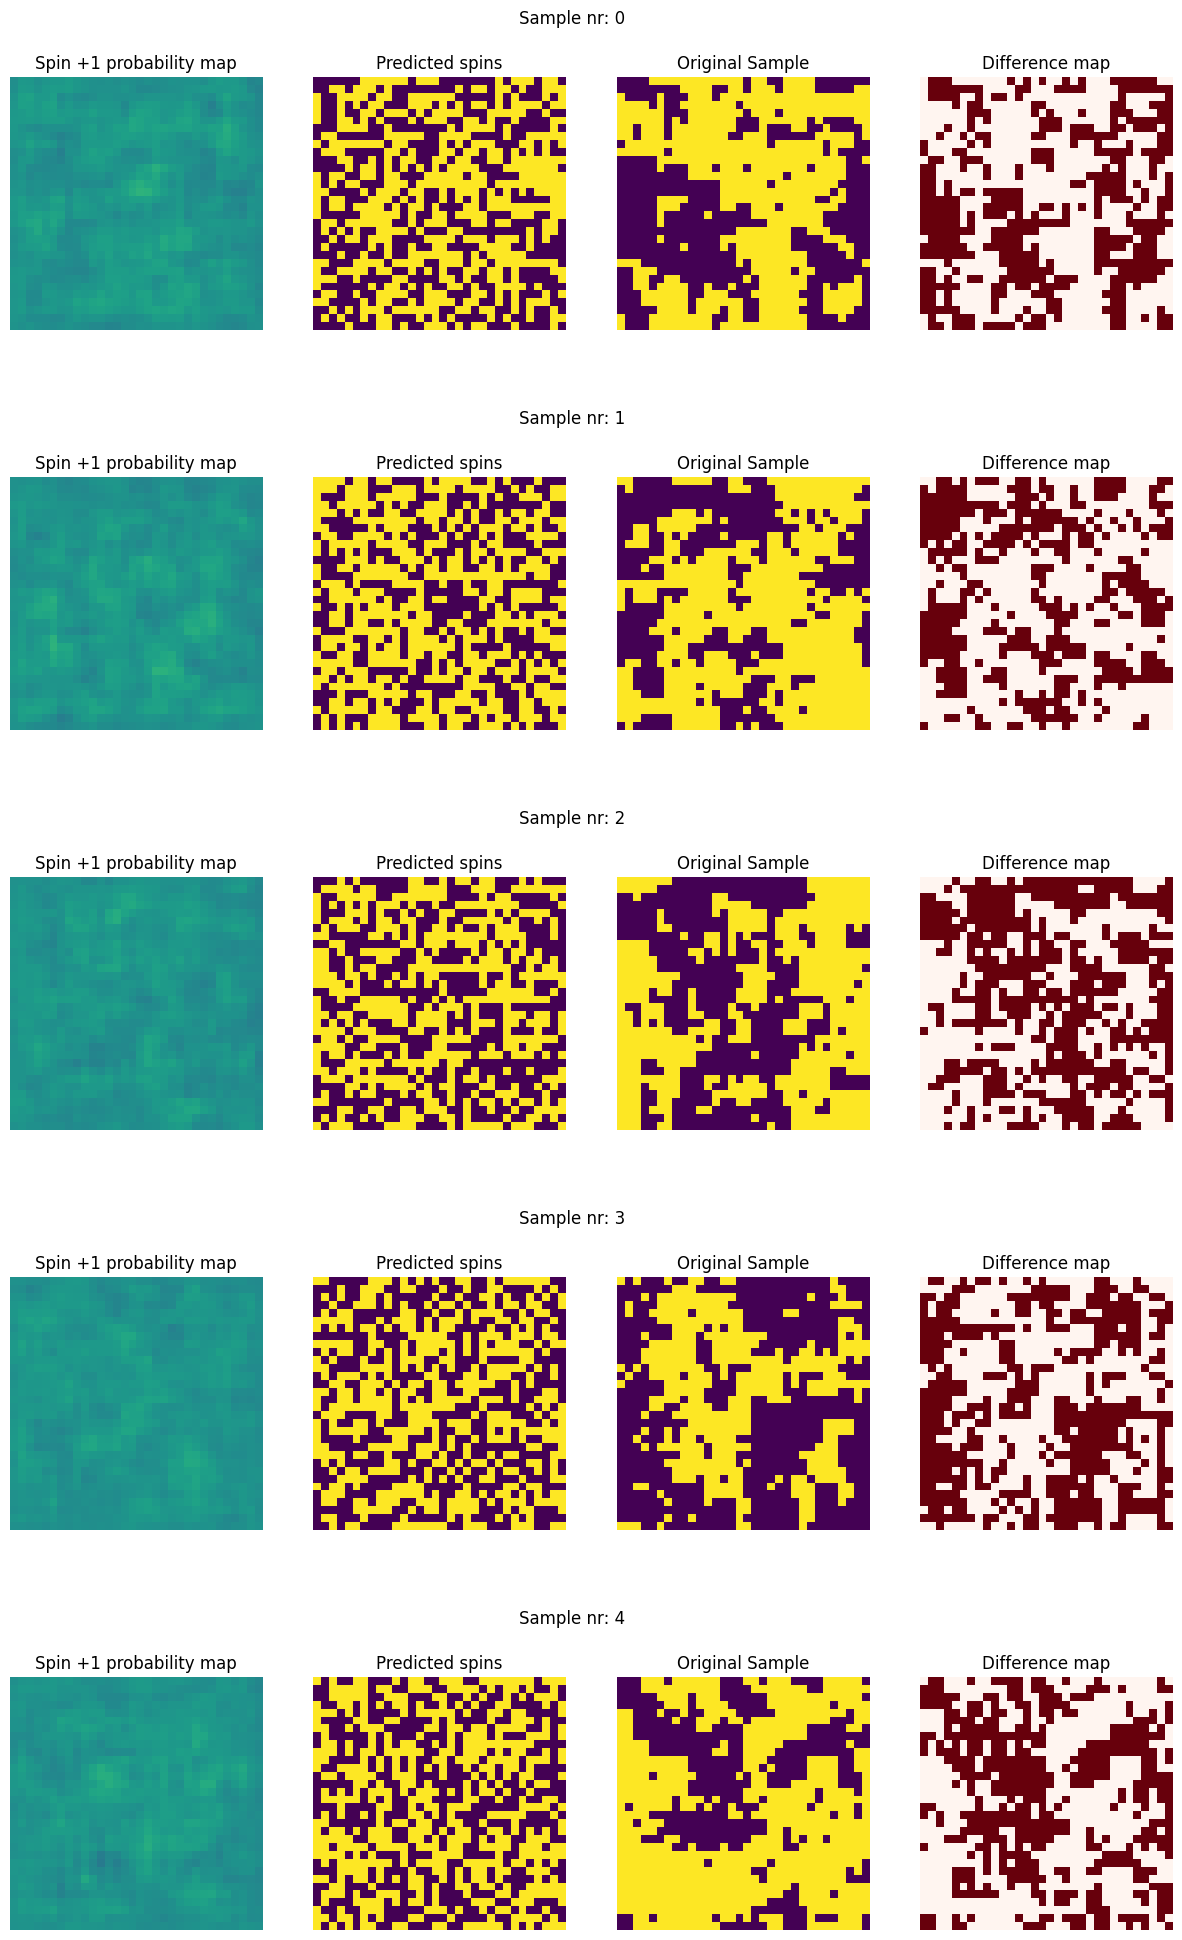

In [21]:
from IPython import display
from time import time
from queue import Queue

loss_monitor = 3 * [False]

loss_list = []
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  time_start = time()
  for train_x in train_set:
    train_step(model, train_x, optimizer)
  loss = tf.keras.metrics.Mean()
  for test_x in test_set:
    loss(compute_loss(model, test_x))

  elbo = -loss.result()
  loss_list.append(loss.result().numpy())

  if epoch > 1:
    loss_monitor.pop(-1)
    loss_monitor.insert(0, loss_list[-1] - loss_list[-2] > 0)
    if all(loss_monitor):
      print("STOP!")
      break

  display.clear_output(wait=False)
  generate_and_save_images(model, epoch, test_sample)
  elapsed = time() - time_start
  print(f'Epoch: {epoch}, Test set ELBO: {elbo}, Time needed: {elapsed}')


In [ ]:
plt.suptitle("Loss function vs Epoch - VAE")
plt.plot(loss_list)
plt.xlabel("Epoch")
plt.xscale("log")
plt.ylabel("Cost function")

In [ ]:
model.save_weights(f'{data_path}/Model/vae.h5',save_format='h5')

In [ ]:
import glob
import contextlib
from PIL import Image

# filepaths
fp_in = f"{data_path}/Images/*.png"
fp_out = f"{data_path}/train.gif"

# use exit stack to automatically close opened images
with contextlib.ExitStack() as stack:

    # lazily load images
    imgs = (stack.enter_context(Image.open(f))
            for f in sorted(glob.glob(fp_in)))

    # extract  first image from iterator
    img = next(imgs)

    # https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
    img.save(fp=fp_out, format='GIF', append_images=imgs,
             save_all=True, duration=2000, loop=0)


# Sample

In [ ]:
def sample(num_examples_to_generate):
    random_mean = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
    log_var = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])

    z = model.reparameterize(random_mean, log_var)
    predictions = model.sample(z)
    return tf.squeeze(predictions)

num_examples_to_generate = 20

## Example simulations

In [ ]:
predictions = sample(num_examples_to_generate)
plt.suptitle("20 image probabilities generated by a model")
for i in range(num_examples_to_generate):
    plt.subplot(4, 5, i + 1)
    plt.gca().axis('off')
    spins = np.random.binomial(1, predictions[i, : , :])
    plt.imshow(spins, vmin=0, vmax=1)
plt.tight_layout()

## Generating 1000 images

In [ ]:
%%time
num_examples_to_generate = 1000
#predictions = sample(num_examples_to_generate)

preds = []
for test_x in test_set:
  preds.append(make_prediction(model, test_x))

predictions = np.concatenate(preds)

In [ ]:
predictions.shape

In [ ]:
spin_predicted =  2 * np.random.binomial(1, predictions) - 1

## Compare distributions with Testset

In [ ]:
def calcEnergy(mat):
    '''Energy of a given configuration'''
    matrix_sum = get_neighbour_sum_matrix(mat)
    return - np.sum(np.multiply(matrix_sum, mat))

def calcMag(mat):
    '''Magnetization of a given configuration'''
    mag = np.sum(mat)
    return mag

def get_neighbour_sum_matrix(mat):
    """Matrix of the sum of spin values for all neighboring cells."""
    # Define shifts for different directions
    shifts = [
        (1, 1),  # Right
        (-1, 1),  # Left
        (-1, 0),  # Up
        (1, 0),  # Down
        (-1, 1),  # Up-Right
        (1, 1),  # Down-Right
        (-1, -1),  # Up-Left
        (1, -1),  # Down-Left
    ]

    # Initialize an empty matrix for the sum of neighboring cells
    neighbor_sum = np.zeros_like(mat)

    # Iterate through each shift and accumulate the values in neighbor_sum
    for shift in shifts:
        shifted_mat = np.roll(mat, shift=shift, axis=(0, 1))
        neighbor_sum += shifted_mat

    return neighbor_sum

In [ ]:
import sys
import pandas as pd
import seaborn as sns

In [ ]:
spin_predicted.shape

In [ ]:
df_model = pd.DataFrame({'image': list(spin_predicted)})
df_model['Magnetization'] = df_model['image'].apply(calcMag)
df_model['Energy'] = df_model['image'].apply(calcEnergy)
df_model.drop(columns='image', inplace=True)
df_model['Algorithm'] = 'VAE'

df_test = pd.DataFrame({"image": list( 2* np.load(testset_path) - 1)})
df_test['Magnetization'] = df_test['image'].apply(calcMag)
df_test['Energy'] = df_test['image'].apply(calcEnergy)
df_test.drop(columns='image', inplace=True)
df_test['Algorithm'] = 'wolff test'

#df_train = pd.DataFrame({"image": list( 2* np.load(trainset_path) - 1)}).sample(1000)
#df_train['Magnetization'] = df_train['image'].apply(calcMag)
#df_train['Energy'] = df_train['image'].apply(calcEnergy)
#df_train.drop(columns='image', inplace=True)
#df_train['Algorithm'] = 'wolff train'

df = pd.concat([df_model, df_test])

In [ ]:
sns.displot(df, x = 'Magnetization', kind ='kde', hue='Algorithm')
sns.displot(df, x = 'Energy', kind ='kde', hue='Algorithm')